# Hyperparameter Tuning using Cross-validation
This notebook explains the theory behind the Cross-validation (CV) and how it can be used to find the optimal hyperparameters. CV is a widely known and commonly used strategy to find good hyperparameters for a given model. **Part 1** therefore briefly explains what the principle is and how it is used. It introduces ordinary CV as well as special cases. **Part 2** provides an example of ordinary CV implemented using the *sklearn* package. **Parts 3&4** are showing the special cases of *k-folded* Cross-validation and *LOOCV*.

## Part 1 - Cross-validation
Cross-validation is a well known and widely used technique for model selection. The idea is to split the available data set into disjoint sets. At least one of which is used for training the model, the other one for validation. The models performance on the validation set is used as estimate for the generalization error. In practice only a fraction of data is used in validation which may lead to performance with large variance.<br/>
To minimize the variance in the generalization *k-fold cross-validation* can be used. In that case the data is split into $\textbf{k}$ disjoint, equally sized subsets and validation is done on a single subset while training uses the union of the remaining $\textbf{k-1}$ subsets. The whole procedure is repeated $\textbf{k}$ times, each time with a different subset for validation. Thus a large fraction of the data used for training. This comes at a price: $\textbf{k}$ models have to be trained and typical values for $\textbf{k}$ are: $\textbf{k} = [3, ..., 10]$. <br/>
There is special case of *k-fold cross-validation* where $\textbf{k} = \textbf{n}$ where $\textbf{n}$ is the absolute number of samples. This is called *Leave One Out Cross-validation (LOOCV)*.
<br/>
Some might ask what the differences if these methods are. There are a lot of answers on the internet and I will try to explain shortly what a lot of them state. Ordinary CV is seen as an *biased* estimate of the generalization error since it does not use all the data available (remember that is uses only $\frac{100*(k-1)}{k}\%$ of the data. And since statistical models tend to perfom better the more data was used in training this method estimates the generalization error with model not optimal trained. Therefore a model trained on all the data (with the optimal hyperparameters found by CV) will perform slightly better than CV suggests. This holds for *k-fold cross-validation* as well eventhough the effect is reduced since each trained model gets a bigger share of the data than in ordinary CV.
<br/>
*LOOCV* on the other hand is assumed to be *unbiased*. It uses most of the data for training (difference between sets is only one sample) but this comes at the cost of higher variance in the generalization error since the training sets overlap more. This makes the estimates from different folds more dependend. 
<br/>
And because the generalization error is a combination for bias and variance (bias-variance dilemma) it is not easy to say which method is better.
<br/> <br/>
Thinking about this twice leads to the question: If the size of the training set in ordinary CV is always smaller than in the other two cases, wouldn't it be common to always use one of the latter ones? To answer this, one has to recall where the variance comes from. A smaller data set makes the model more sensitive to noise and therefore hyperparameters selected by *k-fold cross-validation / LOOCV* may lead to model predictions with lower variance and bias. 

## Part 2 - Ordinary CV
The following code is an example of ordinary CV. The data is drawn from a *RBF* kernal with length scale $l=0.4$ and a signale variance of $\sigma_f^2 = 1.0$ (will be the case for all examples). The data is then split into a training set of $n=38$ samples while the test set has a size of $n=13$ samples. The sets are then used in CV and the optimal estimated hyperparameters are printed. As a metric the $MSE$ is used (other metrics are possible).

In [1]:
import utils
import gpflow
import numpy as np
import matplotlib
import math
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern
from sklearn.model_selection import train_test_split

In [2]:
fontsize_label = 24
fontsize_legend = 20
fontsize_ticks = 20
linewidth = 3
markeredgewidth = 3
markersize = 15 
matplotlib.rcParams['figure.figsize'] = (16, 8)

In [3]:
# Create data set
# sigma_n = 0.0
N = 2000
num_Functions = 10
# Build input space
X = np.linspace(0., 5., N).reshape(N, 1)

In [4]:
np.random.seed(9)
# Draw random function form kernel
num_Functions = 1
lengthscale = 0.4
sigma_f = 1.0
k = gpflow.kernels.RBF(1, lengthscales=lengthscale)
Y_drawn = utils.drawRandomFunction(k, X, num_Functions) 

size = 51
np.random.seed(9)
index = np.random.choice(range(len(X)), size=size, replace=False)
X_sample = X[index]
Y_sample = Y_drawn[index]

(38, 1) (38, 1)
(13, 1) (13, 1)


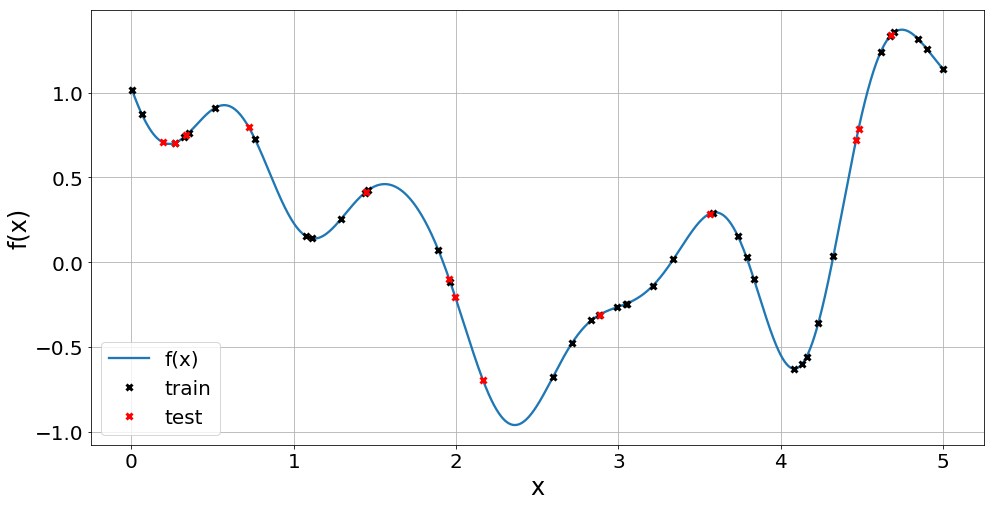

In [5]:
# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(X_sample, Y_sample, test_size=0.25, random_state=0, shuffle=True)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

fig = utils.plot2D(None, None, X, [X, Y_drawn, 'f(x)'], [X_train, y_train, 'train', 'kx'], [X_test, y_test, 'test', 'rx'])

In [6]:
from sklearn.metrics import mean_squared_error

np.random.seed(9)
N_scales = 50
scales = np.logspace(-2, 1, N_scales).reshape(N_scales, 1) # lengthscale 
scores = []

for scale in scales:
    k = sigma_f * RBF(length_scale=scale, length_scale_bounds=(1e-2, 1e3))
    # optimizer=None causes the fit() method to do nothing
    clf = GaussianProcessRegressor(kernel=k, alpha=0.000000001, n_restarts_optimizer=10, optimizer=None)
    clf = clf.fit(X_train, y_train)
    y_est = clf.predict(X_test)
    
    # Calculate MSE
    mse = mean_squared_error(y_test, y_est)
    scores.append({'mse' : mse , 'scale' : scale[0]})

    
minItem = min(scores, key=lambda score:score.get('mse'))
print(minItem)

{'mse': 8.319617362097472e-09, 'scale': 0.3393221771895328}


The estimated lengthscale is already in the range of the true lengthscale.

## Part 3 - k-fold CV
This part shows an example of *k-fold Cross-validation* with 4 folds (to have approximately same sized sets as in **Part 2**). The $MSE$ is smaller than in the previous section but the value for the lengthscale is almost the same.

In [7]:
from sklearn.model_selection import KFold

np.random.seed(9)
folds = 4
N_scales = 50
scales = np.logspace(-2, 1, N_scales).reshape(N_scales, 1) # lengthscale 
kf = KFold(n_splits=folds, shuffle=True)
scores = []

for scale in scales:
    k = sigma_f * RBF(length_scale=scale, length_scale_bounds=(1e-2, 1e3))
    sum_mse = 0
    avg_mse = 0
    for train_index, test_index in kf.split(X_sample):
        X_train, X_test = X_sample[train_index], X_sample[test_index]
        y_train, y_test = Y_sample[train_index], Y_sample[test_index]
        
        clf = GaussianProcessRegressor(kernel=k, alpha=0.000000001, n_restarts_optimizer=10, optimizer=None)
        clf = clf.fit(X_train, y_train)
        y_est = clf.predict(X_test)
        
        sum_mse = sum_mse + mean_squared_error(y_test, y_est)
    avg_mse = sum_mse / folds
    scores.append({'avg_mse' : avg_mse , 'scale' : scale[0]})    
    
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
minItem = min(scores, key=lambda score:score.get('avg_mse'))
print(minItem)

(39, 1) (39, 1)
(12, 1) (12, 1)
{'avg_mse': 9.661069839812307e-07, 'scale': 0.44984326689694465}


## Part 4 - LOOCV
This part shows an example of *LOOCV* with. The $MSE$ is again smaller than in the previous sections but the optimal estimate for the lengthscale is not as good as before. 

In [8]:
from sklearn.model_selection import KFold

np.random.seed(9)
folds = X_sample.shape[0]
N_scales = 50
scales = np.logspace(-2, 1, N_scales).reshape(N_scales, 1) # lengthscale 
kf = KFold(n_splits=folds, shuffle=True)
scores = []

for scale in scales:
    k = sigma_f * RBF(length_scale=scale, length_scale_bounds=(1e-2, 1e3))
    sum_mse = 0
    avg_mse = 0
    for train_index, test_index in kf.split(X_sample):
        X_train, X_test = X_sample[train_index], X_sample[test_index]
        y_train, y_test = Y_sample[train_index], Y_sample[test_index]
        
        clf = GaussianProcessRegressor(kernel=k, alpha=0.000000001, n_restarts_optimizer=10, optimizer=None)
        clf = clf.fit(X_train, y_train)
        y_est = clf.predict(X_test)
        
        sum_mse = sum_mse + mean_squared_error(y_test, y_est)
    avg_mse = sum_mse / folds
    scores.append({'avg_mse' : avg_mse , 'scale' : scale[0]})    
    
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
minItem = min(scores, key=lambda score:score.get('avg_mse'))
print(minItem)

(50, 1) (50, 1)
(1, 1) (1, 1)
{'avg_mse': 4.889227570929361e-08, 'scale': 0.3906939937054617}


## Part 3 - Metric: Predictive Logarithmic Probability
In this part another loss function for the *LOOCV* is introduced. The predictive logarithmic probability (often called pseudo likelihood)is defined as 
\begin{equation*}
log (y_i | X, y_{-i},\theta) = \frac{1}{2} \log(\sigma_i^2) - \frac{(y_i - \mu_i)^2}{2\sigma_i^2} - \frac{1}{2} 2 \pi
\end{equation*}
where $y_{-i}$ is represents all observations except $i$. Mean and variance are computed according to:
\begin{equation*}
\mu_i = k(y_{-i},X) \big[k(X,X) + \sigma_n^2 I\big]^{-1} y_{-i} 
\end{equation*}
and
\begin{equation*}
\sigma_i^2 = k(y_{-i},y_{-i}) - k(y_{-i},X) \big[k(X,X) + \sigma_n^2 I\big]^{-1} k(X,y_{-i})
\end{equation*}
where $k$ is the chosen kernel. When looking closely on the equation one can see that the formula for the mean and the variance rely on the inversion of the matrix $k$. The computational cost of this is $O(n^3)$ once the inverse is known plus $O(n^2)$ for the entire LOOCV.

In [9]:
def pseudo_Likelihood(k, X, Y, sigma_n):
    '''
    Computes the predictive log probability/pseudo likelihood from "Gaussian Processes for Machine Learning"
    Formulas used: 
    5.10
    2.23
    2.24
    '''
    mean = 0.0
    var = 0.0
    pseudo_likelihood = 0.0
    
    # Formula 2.23: Mean
    mean = np.add(k.__call__(X,X), sigma_n * np.identity(X.shape[0]))
    mean = np.linalg.inv(mean)
    inv_product = np.matmul(k.__call__(Y,X),mean) # Save for later use
    mean = np.matmul(inv_product, Y)[0]

    # Formula 2.24: Variance
    var = np.matmul(-inv_product, k.__call__(X, Y))
    var = np.subtract(k.__call__(Y, Y), var)[0]
    
    # Formula 5.10: predictive log probability
    pseudo_likelihood = 0.5 * np.log(var) - ((Y - mean) ** 2) / (2 * var) - 0.5 * np.log(2* np.pi)
    
    return pseudo_likelihood[0][0]

from sklearn.model_selection import KFold

np.random.seed(9)
folds = X_sample.shape[0]
sigma_n = 0.0
N_scales = 50
scales = np.logspace(-2, 1, N_scales).reshape(N_scales, 1) # lengthscale 
kf = KFold(n_splits=folds, shuffle=True)
scores = []

for scale in scales:
    k = sigma_f * RBF(length_scale=scale, length_scale_bounds=(1e-2, 1e3))
    sum_pseudo_likelihood = 0.0
    avg_pseudo_likelihood = 0.0
    for train_index, test_index in kf.split(X_sample):
        X_train, X_test = X_sample[train_index], X_sample[test_index]
        y_train, y_test = Y_sample[train_index], Y_sample[test_index]
        
        clf = GaussianProcessRegressor(kernel=k, alpha=0.000000001, n_restarts_optimizer=10, optimizer=None)
        clf = clf.fit(X_train, y_train)
        y_est = clf.predict(X_test)
        
        sum_pseudo_likelihood = sum_pseudo_likelihood + pseudo_Likelihood(k,y_test, y_est, sigma_n)
    avg_pseudo_likelihood = sum_pseudo_likelihood / folds
    scores.append({'avg_pseudo_likelihood' : avg_pseudo_likelihood , 'scale' : scale[0]})    
    
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
minItem = min(scores, key=lambda score:abs(score.get('avg_pseudo_likelihood')))
print(minItem)

(50, 1) (50, 1)
(1, 1) (1, 1)
{'avg_pseudo_likelihood': -0.572365016261285, 'scale': 0.44984326689694465}


As you can see the *pseudo likelihood loss* function returns the same hyperparameter estimate as the *MSE*.

## General Statement
In general Cross-validation has a higher computational expense ($O(n^3)$) than Logarithmic Marginal Likelihood ($O(n^2)$) since it  requieres the inversion of the covariance matrix. Also different is what both those methods express: LML tells us what the probability of the data is given the assumed model while CV tell us the estimated (log) predictive probability, whether or not the assumptions of the model are fulfilled. See Gaussian Processes for Machine Learning for more details.